<a href="https://colab.research.google.com/github/pranavsrinivas29/Hyperparamter-Optimization/blob/main/Hyp_Opt_Classification_(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Optimisation
## Task: Classification
### Methods used: Grid Search, Random Search, Bayesian Search,Gradient Based Search


In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize
from tensorflow.keras.callbacks import Callback
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize pixel values to be between 0 and 1
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten each image
X_test_flat = X_test.reshape(X_test.shape[0], -1)

subset_size = 1000
X_train_flat, _, y_train, _ = train_test_split(X_train_flat, y_train, train_size=subset_size, random_state=42)

scaler = StandardScaler()
X_train_flat_standardized = scaler.fit_transform(X_train_flat)
X_test_flat_standardized = scaler.transform(X_test_flat)

11490434/11490434 [==============================] - 0s 0us/step


### Grid, Random and Bayesian Model Definition

## Base Model (Benchmark)

In [ ]:
# Record the start time
start_time = time.time()

# Baseline model
baseline_model = Sequential([
    Flatten(input_shape=(X_train_flat_standardized.shape[1],)),
    Dense(64, activation='relu'),
    Dense(10)  # Output layer for 10 classes
])

baseline_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
baseline_model.fit(X_train_flat_standardized, y_train, epochs=5, batch_size=32, verbose=0)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
baseline_time = end_time - start_time

# Evaluate the baseline model on the test set
y_test_pred_baseline_prob = baseline_model.predict(X_test_flat_standardized, verbose=0)
y_test_pred_baseline = np.argmax(y_test_pred_baseline_prob, axis=1)
baseline_accuracy = accuracy_score(y_test, y_test_pred_baseline)

print("Baseline Model Accuracy on Test Set:", baseline_accuracy)
print("Time taken to train the baseline model:", baseline_time, "seconds")

Baseline Model Accuracy on Test Set: 0.4755
Time taken to train the baseline model: 1.5644779205322266 seconds


# Code for Optimization Performance Measurement

We Use 3 Hyperparameters for Optimization Performance Measurement:
- Number of Units in Hidden Layer
- Dropout Rate
- Learning Rate

## Grid, Random and Bayesian Model Definition

In [ ]:
class LSTMClassifier(BaseEstimator):
    def __init__(self, hidden_units=64, dropout_rate=0.2, learning_rate=0.01, epochs=5, batch_size=32):
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        model = Sequential([
            Flatten(input_shape=(X.shape[1],)),
            Dense(self.hidden_units, activation='relu'),
            Dropout(self.dropout_rate),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2, verbose=0)
        self.model = model

    def predict(self, X):
        y_pred = self.model.predict(X, verbose=0)
        return np.argmax(y_pred, axis=1)

## Grid Search

In [ ]:
# Initialize empty lists to store hyperparameters and accuracies
hyperparameters_history_grid = []
accuracies_history_grid = []

param_grid = {
    'hidden_units': [64, 128, 256],
    'dropout_rate': [0.0, 0.2, 0.5, 0.8],
    'learning_rate': [0.001, 0.01, 0.1]
}

grid_start_time = time.time()
grid_search = GridSearchCV(estimator=LSTMClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)
grid_search.fit(X_train_flat_standardized, y_train)
grid_end_time = time.time()

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Extract information about each iteration
results = grid_search.cv_results_
param_names = list(param_grid.keys())

# Calculate the elapsed time for grid search
grid_time = grid_end_time - grid_start_time

# Iterate through the grid search results to collect hyperparameters and accuracies
for i, params in enumerate(results['params']):
    hyperparameters = [params[param_name] for param_name in param_names]
    accuracy = results['mean_test_score'][i]
    hyperparameters_history_grid.append(hyperparameters)
    accuracies_history_grid.append(accuracy)


In [ ]:
best_hidden_units = grid_search.best_params_['hidden_units']
best_dropout_rate = grid_search.best_params_['dropout_rate']
best_learning_rate = grid_search.best_params_['learning_rate']

final_model = LSTMClassifier(hidden_units=best_hidden_units, dropout_rate=best_dropout_rate, learning_rate=best_learning_rate)
final_model.fit(X_train_flat_standardized, y_train)
y_test_pred = final_model.predict(X_test_flat_standardized)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Best Hyperparameters:", best_params)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)
print("Time taken for grid search:", grid_time, "seconds")

Best Hyperparameters: {'dropout_rate': 0.2, 'hidden_units': 256, 'learning_rate': 0.001}
Test Accuracy with Best Hyperparameters: 0.8697
Time taken for grid search: 127.88940453529358 seconds


In [ ]:
print(hyperparameters_history_grid)
print(accuracies_history_grid)


[[64, 0.0, 0.001], [64, 0.0, 0.01], [64, 0.0, 0.1], [128, 0.0, 0.001], [128, 0.0, 0.01], [128, 0.0, 0.1], [256, 0.0, 0.001], [256, 0.0, 0.01], [256, 0.0, 0.1], [64, 0.2, 0.001], [64, 0.2, 0.01], [64, 0.2, 0.1], [128, 0.2, 0.001], [128, 0.2, 0.01], [128, 0.2, 0.1], [256, 0.2, 0.001], [256, 0.2, 0.01], [256, 0.2, 0.1], [64, 0.5, 0.001], [64, 0.5, 0.01], [64, 0.5, 0.1], [128, 0.5, 0.001], [128, 0.5, 0.01], [128, 0.5, 0.1], [256, 0.5, 0.001], [256, 0.5, 0.01], [256, 0.5, 0.1], [64, 0.8, 0.001], [64, 0.8, 0.01], [64, 0.8, 0.1], [128, 0.8, 0.001], [128, 0.8, 0.01], [128, 0.8, 0.1], [256, 0.8, 0.001], [256, 0.8, 0.01], [256, 0.8, 0.1]]
[0.8200026373679069, 0.8549837262412113, 0.7590434746123368, 0.8369836902771034, 0.8439877002751254, 0.8039836243429058, 0.8529967092841343, 0.8460046873220527, 0.7910095724466982, 0.8359916803030575, 0.8519867172561782, 0.7959786133438828, 0.8540096983210755, 0.8410176643709578, 0.7939975904047761, 0.8639987292681903, 0.8289816762870655, 0.795004585423747, 0.8

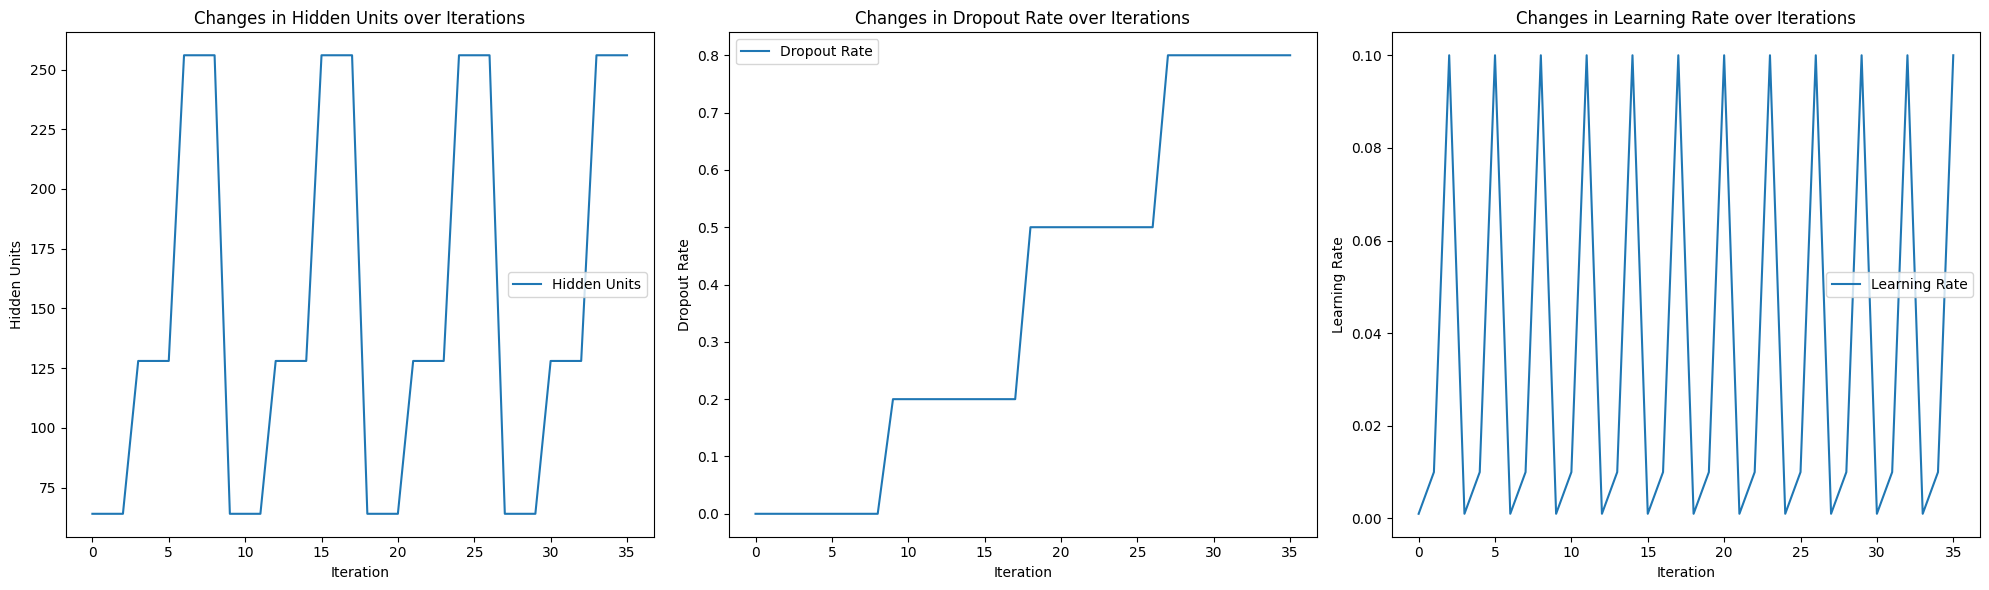

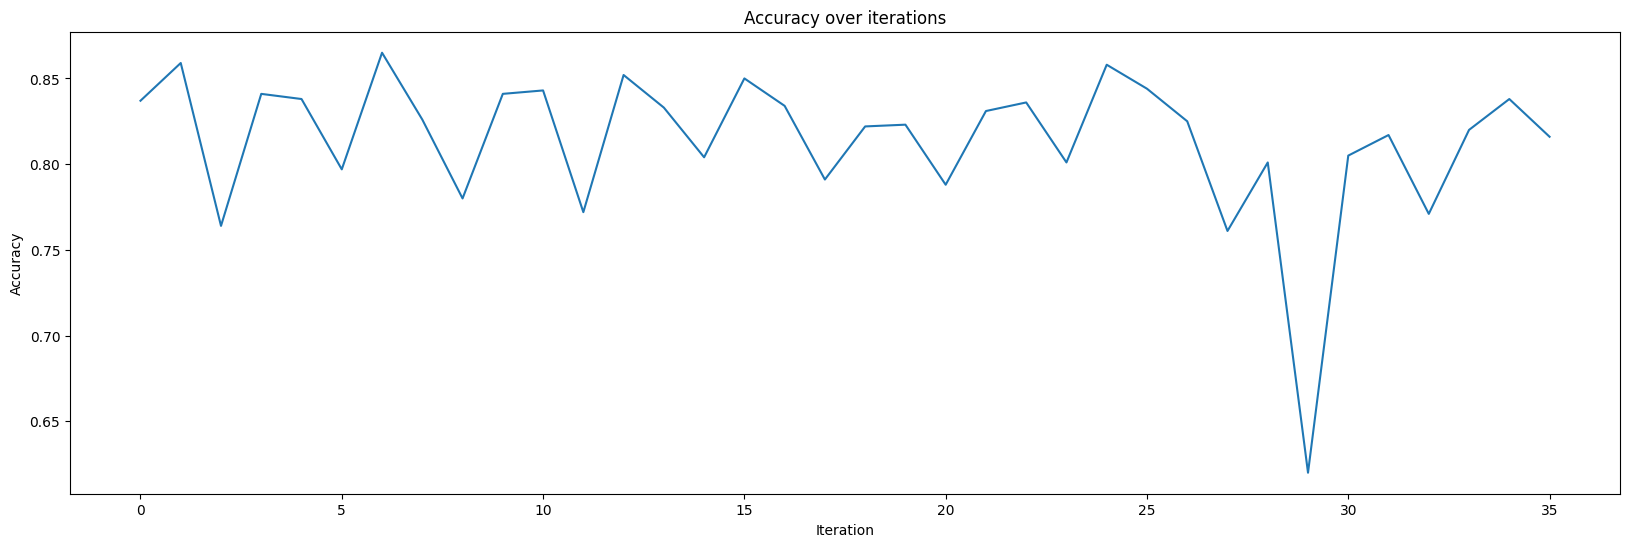

In [ ]:
import matplotlib.pyplot as plt

hidden_units_history = [params[0] for params in hyperparameters_history_grid]
dropout_rate_history = [params[1] for params in hyperparameters_history_grid]
learning_rate_history = [params[2] for params in hyperparameters_history_grid]

plt.figure(figsize=(20, 6))

# Plot for Hidden Units
plt.subplot(1, 3, 1)
plt.plot(hidden_units_history, label='Hidden Units')
plt.xlabel('Iteration')
plt.ylabel('Hidden Units')
plt.title('Changes in Hidden Units over Iterations')
plt.legend()

# Plot for Dropout Rate
plt.subplot(1, 3, 2)
plt.plot(dropout_rate_history, label='Dropout Rate')
plt.xlabel('Iteration')
plt.ylabel('Dropout Rate')
plt.title('Changes in Dropout Rate over Iterations')
plt.legend()

# Plot for Learning Rate
plt.subplot(1, 3, 3)
plt.plot(learning_rate_history, label='Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Changes in Learning Rate over Iterations')
plt.legend()

plt.tight_layout()
plt.show()

#plot the accuracies changes over iterations
plt.figure(figsize=(20, 6))
plt.plot(accuracies_history_grid)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations')
plt.show()


## Random Search

In [ ]:
# Define the hyperparameter search space
param_dist = {
    'hidden_units': [64, 128, 256],
    'dropout_rate': [0.0, 0.2, 0.5, 0.8],
    'learning_rate': [0.001, 0.01, 0.1]
}

lstm_classifier = LSTMClassifier()
hyperparameters_history_random = []
accuracies_history_random = []

# Record the start time for random search
random_search_start_time = time.time()

random_search = RandomizedSearchCV(estimator=lstm_classifier, param_distributions=param_dist,
                                   n_iter=10, cv=3, scoring='accuracy', verbose=1)
random_search.fit(X_train_flat_standardized, y_train)

# Record the end time for random search
random_search_end_time = time.time()

best_params_random = random_search.best_params_
best_accuracy_random = random_search.best_score_

# Calculate the elapsed time for random search
random_time = random_search_end_time - random_search_start_time

results_random = random_search.cv_results_
param_names_random = list(param_dist.keys())

for i, params in enumerate(results_random['params']):
    hyperparameters = [params[param_name] for param_name in param_names_random]
    accuracy = results_random['mean_test_score'][i]
    hyperparameters_history_random.append(hyperparameters)
    accuracies_history_random.append(accuracy)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
best_hidden_units_random = random_search.best_params_['hidden_units']
best_dropout_rate_random = random_search.best_params_['dropout_rate']
best_learning_rate_random = random_search.best_params_['learning_rate']

final_model_random = LSTMClassifier(hidden_units=best_hidden_units_random,
                                    dropout_rate=best_dropout_rate_random,
                                    learning_rate=best_learning_rate_random)
final_model_random.fit(X_train_flat_standardized, y_train)

y_test_pred_random = final_model_random.predict(X_test_flat_standardized)
test_accuracy_random = accuracy_score(y_test, y_test_pred_random)

print("Best Hyperparameters (Random Search):", best_params_random)
print("Test Accuracy with Best Hyperparameters (Random Search):", test_accuracy_random)
print("Time taken for Random search:", random_time, "seconds")

Best Hyperparameters (Random Search): {'learning_rate': 0.001, 'hidden_units': 256, 'dropout_rate': 0.0}
Test Accuracy with Best Hyperparameters (Random Search): 0.8639
Time taken for Random search: 30.48298215866089 seconds


In [ ]:
print(hyperparameters_history_random)
print(accuracies_history_random)


[[256, 0.2, 0.001], [256, 0.8, 0.1], [64, 0.5, 0.1], [64, 0.2, 0.01], [256, 0.0, 0.001], [128, 0.2, 0.1], [64, 0.2, 0.001], [256, 0.2, 0.01], [64, 0.8, 0.1], [128, 0.0, 0.1]]
[0.8569797342252432, 0.8199996403589217, 0.7699975424526323, 0.8499967032901165, 0.8629917342492193, 0.8019726313139488, 0.8409936882990774, 0.8349996703290117, 0.6179712646778515, 0.7809995624366882]


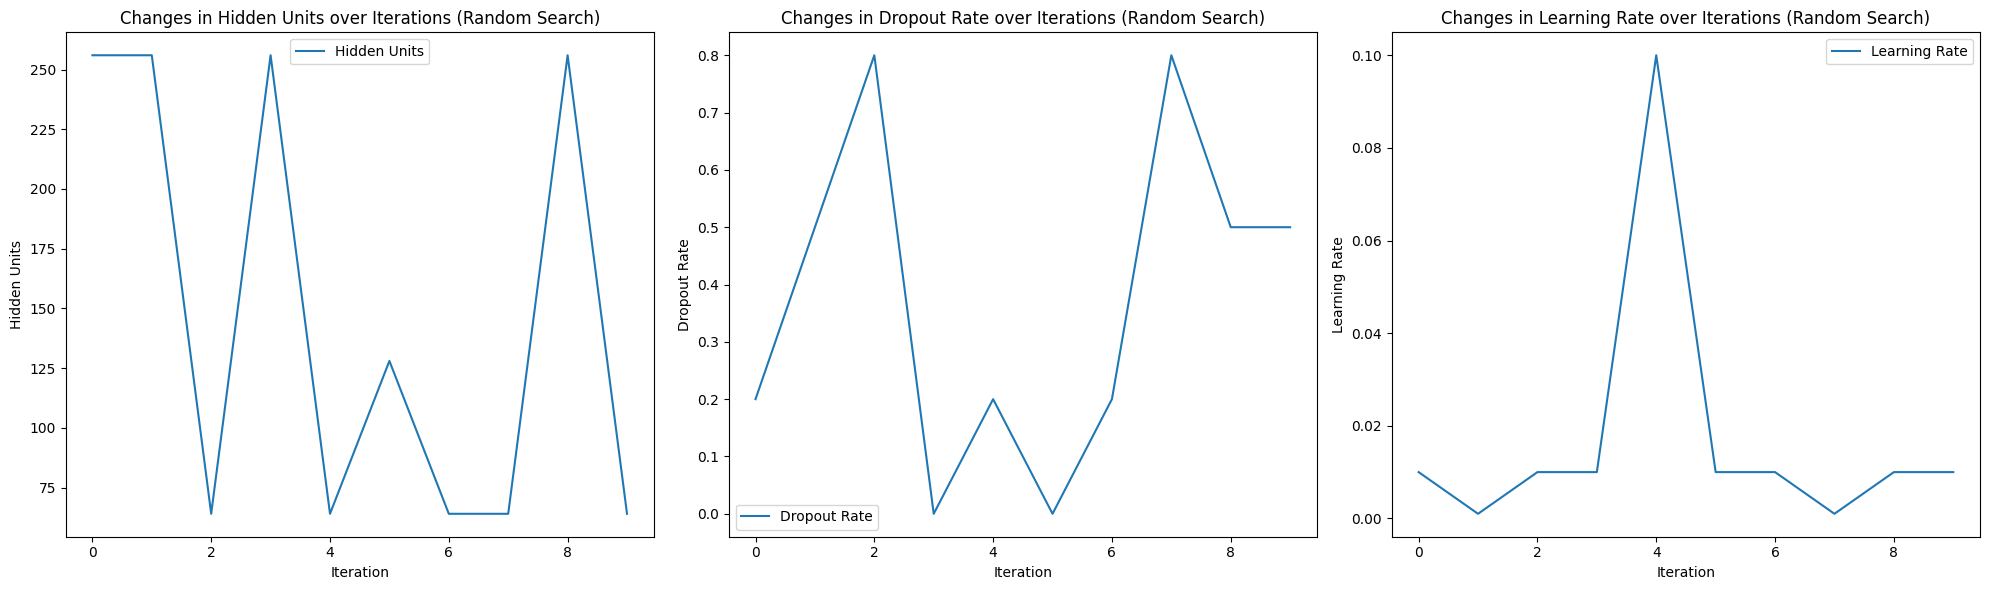

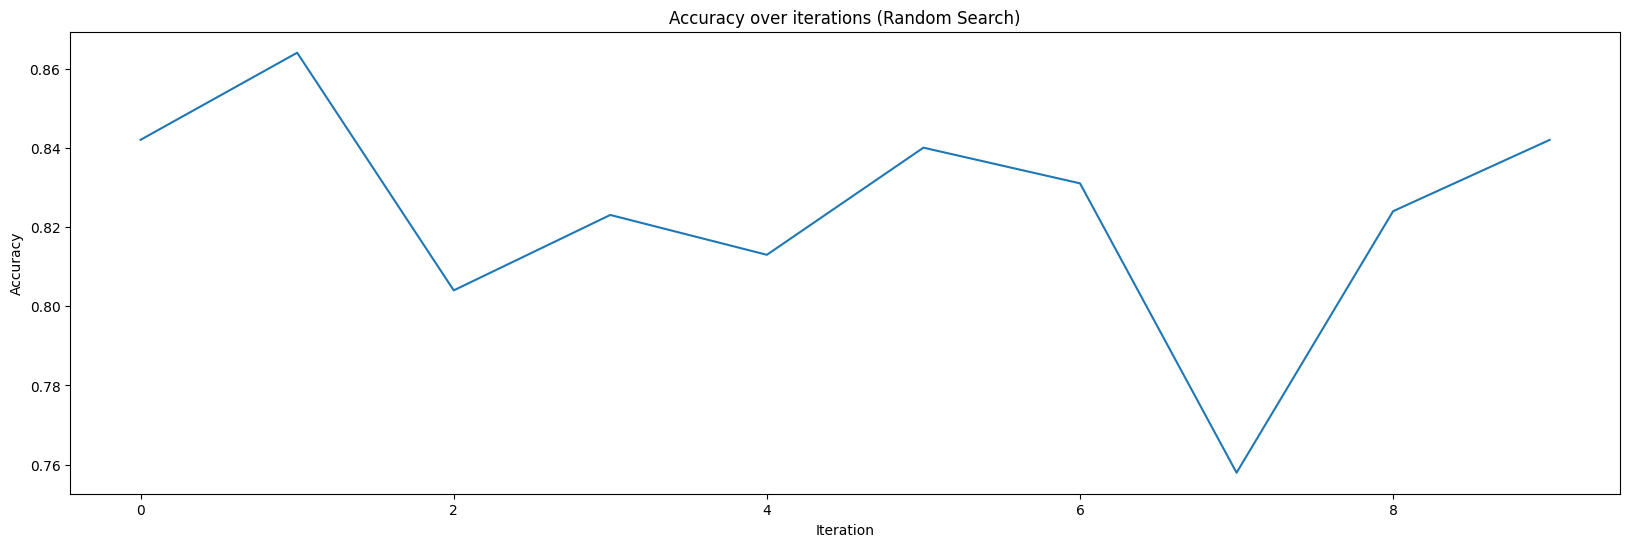

In [ ]:
# Plot the changes in hyperparameters over iterations
hidden_units_history_random = [params[0] for params in hyperparameters_history_random]
dropout_rate_history_random = [params[1] for params in hyperparameters_history_random]
learning_rate_history_random = [params[2] for params in hyperparameters_history_random]

plt.figure(figsize=(20, 6))

# Plot for Hidden Units
plt.subplot(1, 3, 1)
plt.plot(hidden_units_history_random, label='Hidden Units')
plt.xlabel('Iteration')
plt.ylabel('Hidden Units')
plt.title('Changes in Hidden Units over Iterations (Random Search)')
plt.legend()

# Plot for Dropout Rate
plt.subplot(1, 3, 2)
plt.plot(dropout_rate_history_random, label='Dropout Rate')
plt.xlabel('Iteration')
plt.ylabel('Dropout Rate')
plt.title('Changes in Dropout Rate over Iterations (Random Search)')
plt.legend()

# Plot for Learning Rate
plt.subplot(1, 3, 3)
plt.plot(learning_rate_history_random, label='Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Changes in Learning Rate over Iterations (Random Search)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the accuracies changes over iterations
plt.figure(figsize=(20, 6))
plt.plot(accuracies_history_random)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations (Random Search)')
plt.show()

## Bayesian Optimization

In [ ]:
# Define the hyperparameter search space
param_space = {
    'hidden_units': Integer(64, 256),
    'dropout_rate': Real(0.0, 0.8),
    'learning_rate': Real(1e-4, 0.1)
}

hyperparameters_history_bayes = []
accuracies_history_bayes = []

# Record the start time for Bayesian search
bays_start_time = time.time()

bayes_search = BayesSearchCV(
    LSTMClassifier(),
    param_space,
    cv=3,  # Number of cross-validation folds
    scoring='accuracy'
)

bayes_search.fit(X_train_flat_standardized, y_train)

# Record the end time for Bayesian search
bays_end_time = time.time()

best_hyperparameters_bayes = bayes_search.best_params_

# Calculate the elapsed time for Bayesian search
bayes_time = bays_end_time - bays_start_time

for i, params in enumerate(bayes_search.cv_results_['params']):
    hyperparameters = [params[param_name] for param_name in param_space.keys()]
    accuracy = bayes_search.cv_results_['mean_test_score'][i]
    hyperparameters_history_bayes.append(hyperparameters)
    accuracies_history_bayes.append(accuracy)

In [ ]:
best_model_bayesian = LSTMClassifier(**best_hyperparameters_bayes)
best_model_bayesian.fit(X_train_flat_standardized, y_train)
y_test_pred_bayes = best_model_bayesian.predict(X_test_flat_standardized)
test_accuracy_bayes = accuracy_score(y_test, y_test_pred_bayes)

print("Best Hyperparameters (Bayesian Optimization):", best_hyperparameters_bayes)
print("Test Accuracy with Best Hyperparameters:", test_accuracy_bayes)
print("Time taken for Bayesian Optimisation:", bayes_time, "seconds")

Best Hyperparameters (Bayesian Optimization): OrderedDict([('dropout_rate', 0.16102404219239327), ('hidden_units', 141), ('learning_rate', 0.006314741506989356)])
Test Accuracy with Best Hyperparameters: 0.8697
Time taken for Bayesian Optimisation: 216.49872612953186 seconds


In [ ]:
print(hyperparameters_history_bayes)
print(accuracies_history_bayes)

[[170, 0.46380348125350146, 0.016427500062467442], [168, 0.18518236276500033, 0.05862551309051893], [179, 0.5553950699116574, 0.04154380539006869], [121, 0.7261536543982046, 0.0034471020921461835], [252, 0.7528880161871438, 0.00624939343344945], [129, 0.4963927300140606, 0.04307800748754492], [162, 0.3056661450174524, 0.009793017755009533], [138, 0.6240524567884939, 0.030428650989441343], [124, 0.725204179591356, 0.07354753429236814], [90, 0.7353526528722382, 0.041568223896829945], [64, 0.24290099691788167, 0.0001], [147, 0.33137545322944323, 0.0001], [220, 0.47947790110045463, 0.010608215925364338], [249, 0.2502637973158377, 0.014184841189131431], [188, 0.34550977376381825, 0.011356381294825241], [256, 0.15475817289093008, 0.03587843575251213], [92, 0.8, 0.004279516249953085], [81, 0.5686263250196071, 0.00786957667509104], [90, 0.08702761263375311, 0.022314386798208363], [206, 0.8, 0.0009882414982340941], [214, 0.8, 0.02171717712964991], [205, 0.0, 0.1], [248, 0.4847463995085959, 0.02

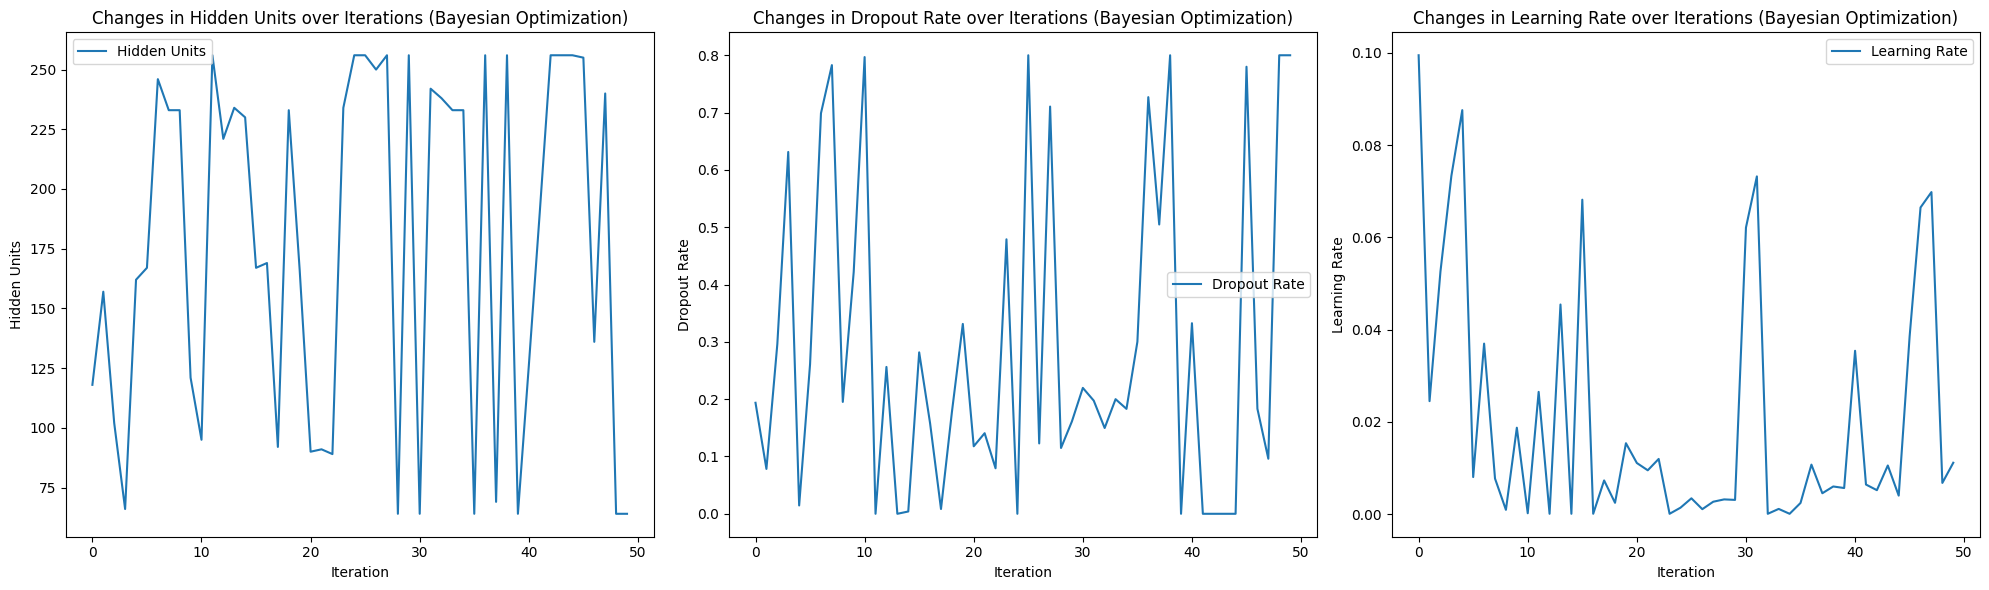

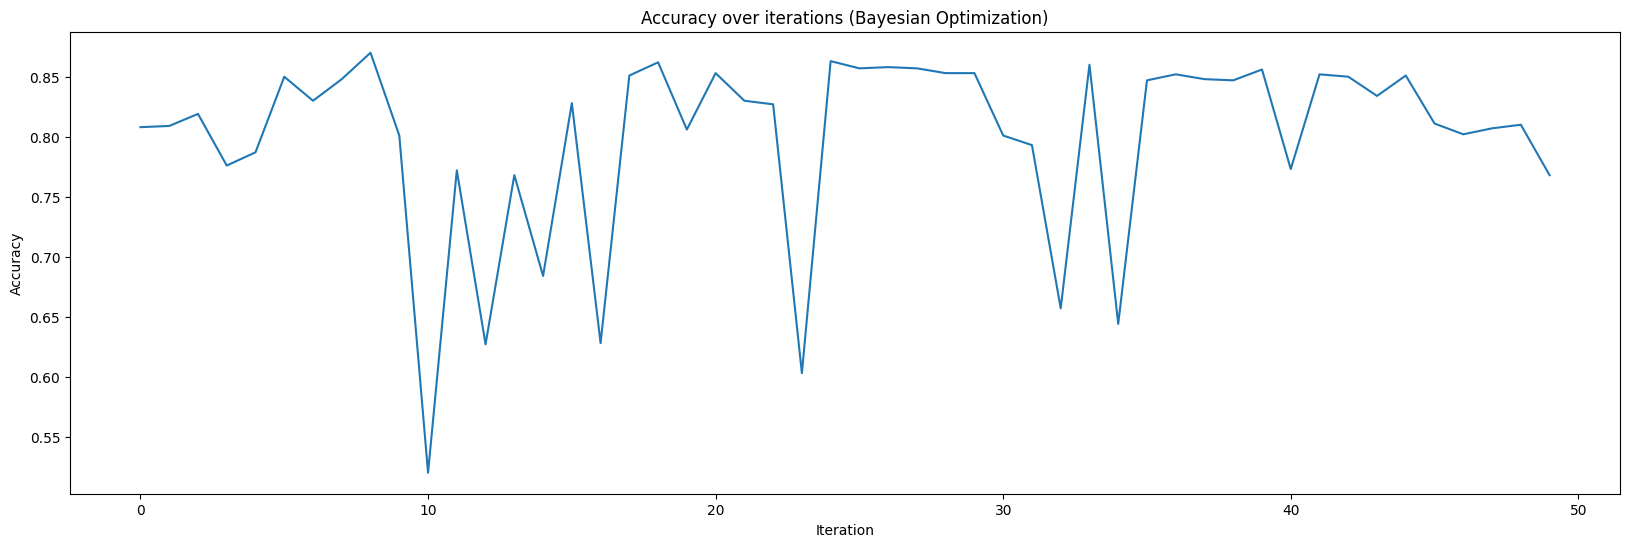

In [ ]:
#plot the changes in hyperparameters over iterations
hidden_units_history_bayes = [params[0] for params in hyperparameters_history_bayes]
dropout_rate_history_bayes = [params[1] for params in hyperparameters_history_bayes]
learning_rate_history_bayes = [params[2] for params in hyperparameters_history_bayes]

plt.figure(figsize=(20, 6))

# Plot for Hidden Units
plt.subplot(1, 3, 1)
plt.plot(hidden_units_history_bayes, label='Hidden Units')
plt.xlabel('Iteration')
plt.ylabel('Hidden Units')
plt.title('Changes in Hidden Units over Iterations (Bayesian Optimization)')
plt.legend()

# Plot for Dropout Rate
plt.subplot(1, 3, 2)
plt.plot(dropout_rate_history_bayes, label='Dropout Rate')
plt.xlabel('Iteration')
plt.ylabel('Dropout Rate')
plt.title('Changes in Dropout Rate over Iterations (Bayesian Optimization)')
plt.legend()

# Plot for Learning Rate
plt.subplot(1, 3, 3)
plt.plot(learning_rate_history_bayes, label='Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Changes in Learning Rate over Iterations (Bayesian Optimization)')
plt.legend()

plt.tight_layout()
plt.show()

#plot the accuracies changes over iterations
plt.figure(figsize=(20, 6))
plt.plot(accuracies_history_bayes)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations (Bayesian Optimization)')
plt.show()


## Gradient-based Optimization

#### Defining the Objective Function

In [ ]:
hyperparameters_history_gb = []
accuracies_history_gb = []

def create_and_train_nn(hyperparameters):
    dropout_rate, learning_rate, units = hyperparameters
    model = Sequential([
        Flatten(input_shape=(X_train_flat_standardized.shape[1],)),
        Dense(units, activation='sigmoid'),  # Modified to use 'units'
        Dropout(dropout_rate),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_flat_standardized, y_train, epochs=5, batch_size=32, verbose=0)
    return model

def negative_accuracy(hyperparameters):
    model = create_and_train_nn(hyperparameters)
    y_pred = np.argmax(model.predict(X_test_flat_standardized, verbose=0), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    hyperparameters_history_gb.append(hyperparameters)
    accuracies_history_gb.append(accuracy)
    return -accuracy

### Performing Optimization

In [ ]:
initial_hyperparameters = [round(np.random.uniform(32, 256), 4), round(np.random.uniform(0, 0.8), 4), round(np.random.uniform(0.001, 0.1), 4)]
print('Initial Parameters:', initial_hyperparameters)
bounds=[(0, 0.99), (1e-4, 0.1), (32, 256)]  # Bounds for dropout_rate, learning_rate, and units

gb_opt_start_time = time.time()
result = minimize(negative_accuracy, initial_hyperparameters, method='L-BFGS-B', bounds=bounds,
                  options={'disp': True})
gb_opt_end_time = time.time()

optimized_hyperparameters = result.x
optimized_dropout_rate, optimized_learning_rate, optimized_units = optimized_hyperparameters

gb_opt_time = gb_opt_end_time - gb_opt_start_time

In [ ]:
final_model = create_and_train_nn(optimized_hyperparameters)
y_test_pred = np.argmax(final_model.predict(X_test_flat_standardized, verbose=0), axis=1)
final_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Optimized Hyperparameters - Dropout Rate: {optimized_dropout_rate}, Learning Rate: {optimized_learning_rate}, Units: {optimized_units}")
print(f"Final Model Accuracy on Test Set: {final_accuracy}")
print("Time taken for Gradient-based Optimization:", gb_opt_time, "seconds")

# Record the changes in hyperparameters over iterations
dropout_rate_history_gb = [params[0] for params in hyperparameters_history_gb]
learning_rate_history_gb = [params[1] for params in hyperparameters_history_gb]
units_history_gb = [params[2] for params in hyperparameters_history_gb]

Optimized Hyperparameters - Dropout Rate: 0.1999999863445347, Learning Rate: 0.009999997768848556, Units: 127.99999743659507
Final Model Accuracy on Test Set: 0.8742
Time taken for Gradient-based Optimization: 275.68860363960266 seconds


In [ ]:
print(optimized_hyperparameters)
print(accuracies_history_gb)

[1.99999986e-01 9.99999777e-03 1.27999997e+02]
[0.875, 0.874, 0.87]


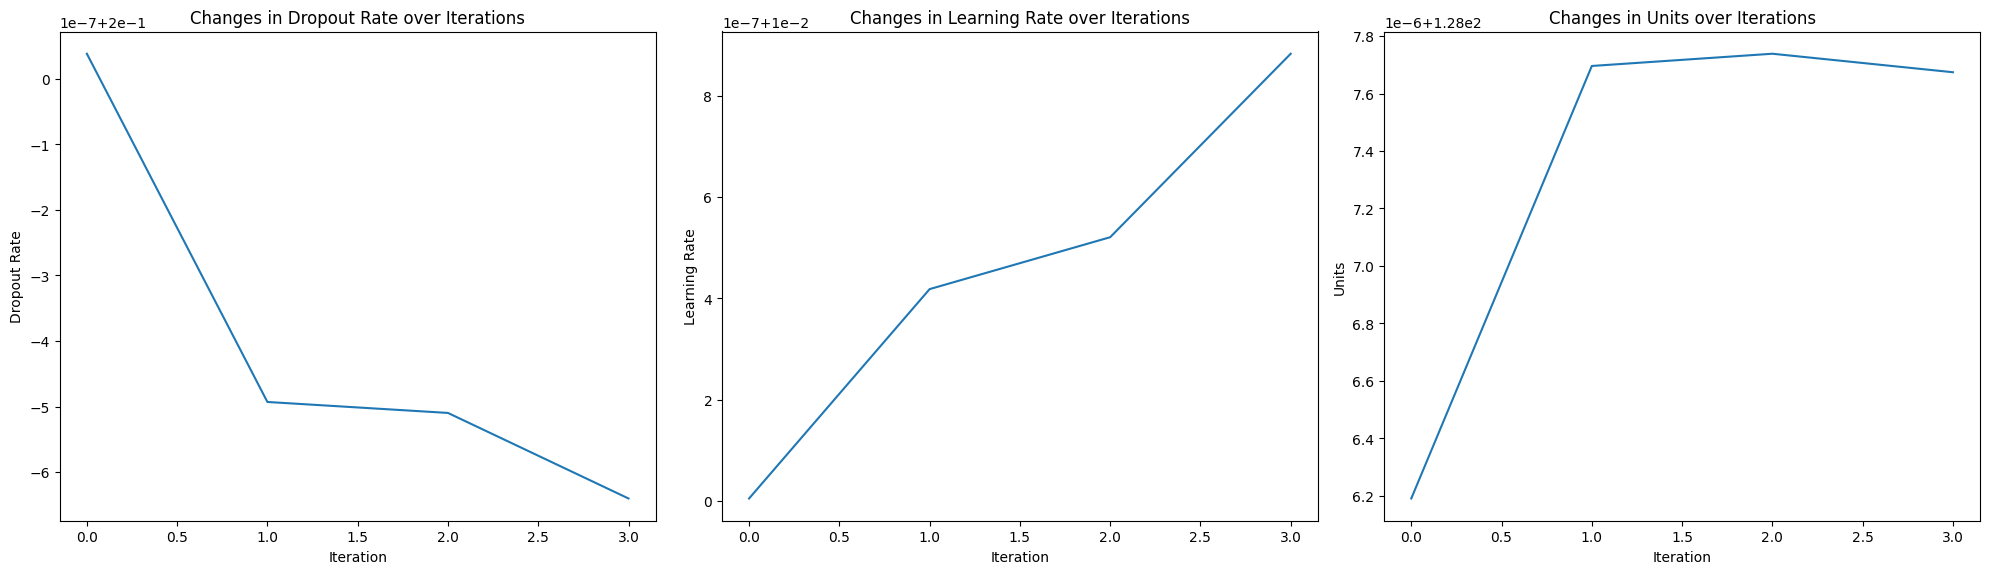

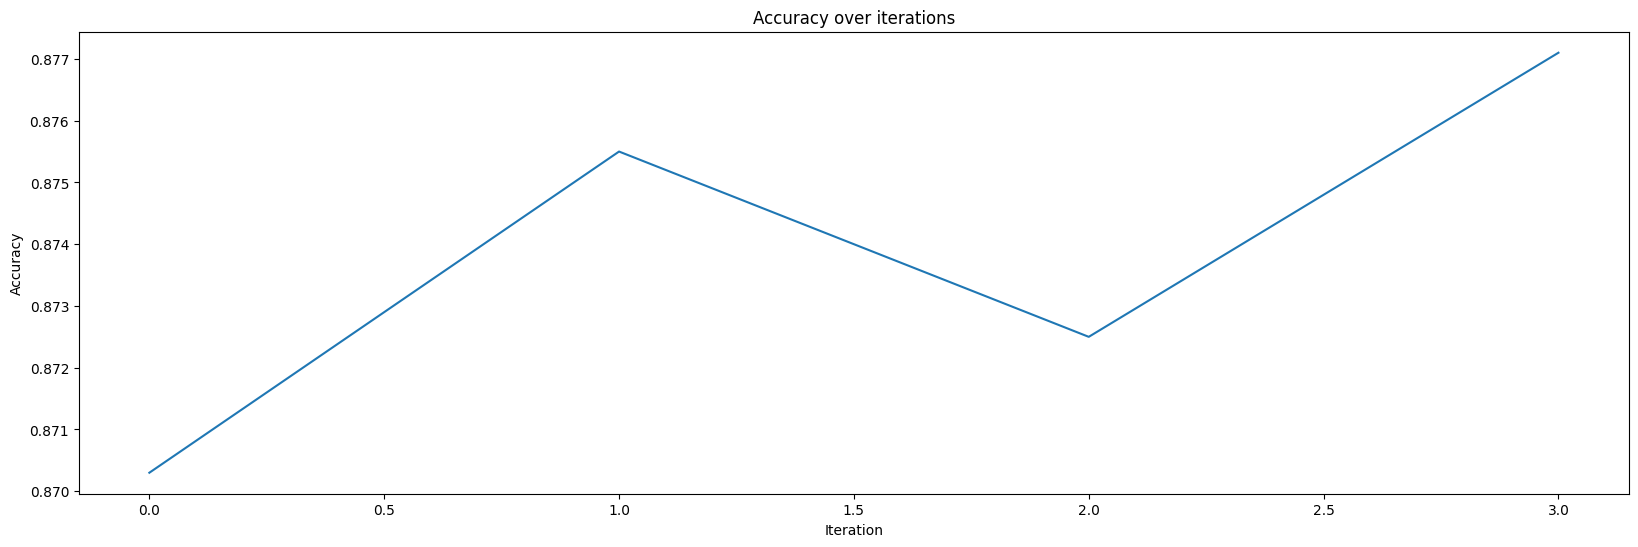

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set default style to whitegrid
sns.set(style="whitegrid")

# Plot the changes in hyperparameters over iterations
plt.figure(figsize=(20, 6))

# Plot for Dropout Rate
plt.subplot(1, 3, 1)
plt.plot(dropout_rate_history_gb)
plt.xlabel('Iteration')
plt.ylabel('Dropout Rate')
plt.title('Changes in Dropout Rate over Iterations')
plt.grid(True)

# Plot for Learning Rate
plt.subplot(1, 3, 2)
plt.plot(learning_rate_history_gb)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Changes in Learning Rate over Iterations')
plt.grid(True)

# Plot for Units
plt.subplot(1, 3, 3)  # Corrected the subplot index
plt.plot(units_history_gb)
plt.xlabel('Iteration')
plt.ylabel('Units')
plt.title('Changes in Units over Iterations')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the accuracies changes over iterations
plt.figure(figsize=(20, 6))
plt.plot(accuracies_history_gb)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations')
plt.grid(True)
plt.show()


## Evaluating the Results

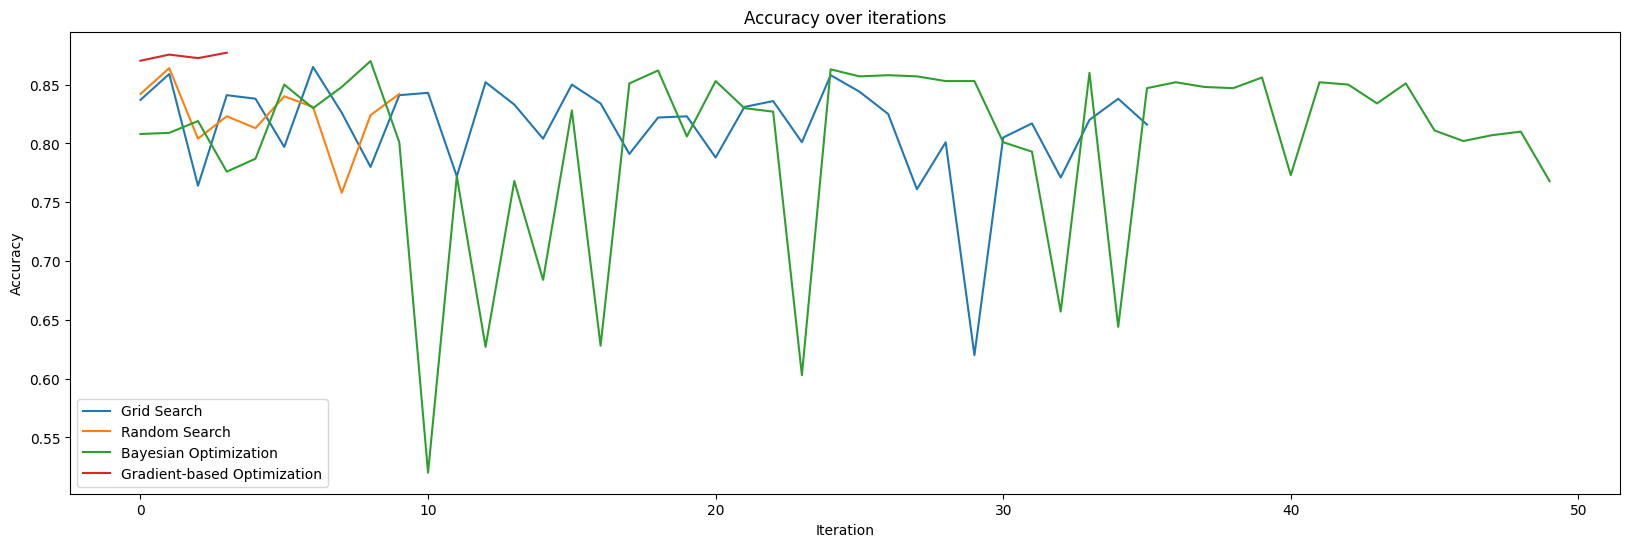

In [ ]:
#plot all the accuracies changes over iterations
plt.figure(figsize=(20, 6))
plt.plot(accuracies_history_grid, label='Grid Search')
plt.plot(accuracies_history_random, label='Random Search')
plt.plot(accuracies_history_bayes, label='Bayesian Optimization')
plt.plot(accuracies_history_gb, label='Gradient-based Optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations')
plt.legend()
plt.show()


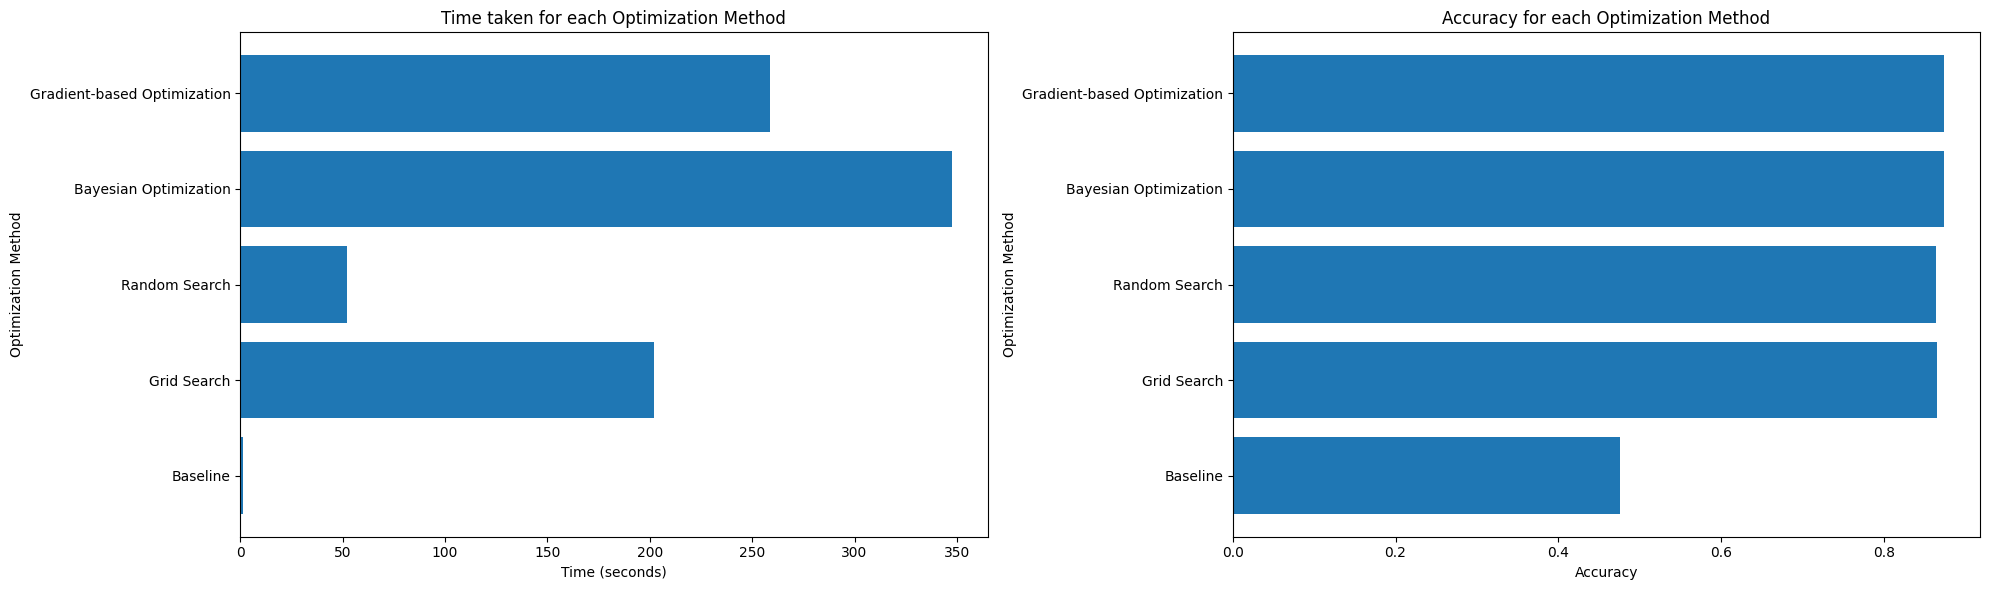

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.barh(['Baseline', 'Grid Search', 'Random Search', 'Bayesian Optimization', 'Gradient-based Optimization'],
         [baseline_time, grid_time, random_time, bayes_time, gb_opt_time])
plt.xlabel('Time (seconds)')
plt.ylabel('Optimization Method')
plt.title('Time taken for each Optimization Method')

plt.subplot(1, 2, 2)
plt.barh(['Baseline', 'Grid Search', 'Random Search', 'Bayesian Optimization', 'Gradient-based Optimization'],
         [baseline_accuracy, best_accuracy, best_accuracy_random, test_accuracy_bayes, final_accuracy])
plt.xlabel('Accuracy')
plt.ylabel('Optimization Method')
plt.title('Accuracy for each Optimization Method')

plt.tight_layout()
plt.show()


# Code for Optimization Visualisation

We Use 2 Hyperparameters (To plot on x and y axis) and output on z-axis to Visualise the Optimisation Process:
- Dropout Rate
- Learning Rate

## Grid, Random and Bayesian Model Definition

In [ ]:
def classification_model(dropout_rate, learning_rate):
    np.random.seed(42)

    model = Sequential([
        Flatten(input_shape=(X_train_flat_standardized.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

class LSTMClassifier(BaseEstimator):
    def __init__(self, dropout_rate=0.2, learning_rate=0.01, epochs=5, batch_size=32):
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        model = classification_model(dropout_rate=self.dropout_rate, learning_rate=self.learning_rate)
        model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2, verbose=0)
        self.model = model

    def predict(self, X):
        y_pred = np.argmax(self.model.predict(X, verbose=0), axis=1)
        return y_pred

def objective_function_grid(hyperparameters):
    dropout_rate, learning_rate = hyperparameters
    model = classification_model(dropout_rate=dropout_rate, learning_rate=learning_rate)
    model.fit(X_train_flat_standardized, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = np.argmax(model.predict(X_test_flat_standardized, verbose=0), axis=1)
    test_accuracy = accuracy_score(y_test, y_pred)
    return test_accuracy  # Negate for minimization

## Grid, Random and Bayesian Optimization Meshgrid Initialisation

In [ ]:
# Create a meshgrid for visualization
dropout_rate_range = np.linspace(0, 0.99, 15)
learning_rate_range = np.linspace(0.001, 0.1, 15)
X, Y = np.meshgrid(dropout_rate_range, learning_rate_range)

# Calculate accuracy for each point in the meshgrid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = objective_function_grid([X[i, j], Y[i, j]])


## Grid Search

In [ ]:
param_grid = {
    'dropout_rate': [0.0, 0.2, 0.5, 0.8],
    'learning_rate': [0.001, 0.01, 0.1]
}

grid_start_time = time.time()
grid_search = GridSearchCV(estimator=LSTMClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train_flat_standardized, y_train)
grid_end_time = time.time()

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Extract information about each iteration
results = grid_search.cv_results_

# Calculate the elapsed time for grid search
grid_time = grid_end_time - grid_start_time

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
best_dropout_rate = grid_search.best_params_['dropout_rate']
best_learning_rate = grid_search.best_params_['learning_rate']

final_model = LSTMClassifier(dropout_rate=best_dropout_rate, learning_rate=best_learning_rate)
final_model.fit(X_train_flat_standardized, y_train)
y_test_pred = final_model.predict(X_test_flat_standardized)
test_accuracy = accuracy_score(y_test, y_test_pred)

hyperparameters_history_grid = grid_search.cv_results_['params']
hyperparameter_names_grid = list(hyperparameters_history_grid[0].keys())
accuracy_history_grid = grid_search.cv_results_['mean_test_score']

print("Best Hyperparameters:", best_params)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)
print("Time taken for grid search:", grid_time, "seconds")

Best Hyperparameters: {'dropout_rate': 0.2, 'learning_rate': 0.001}
Test Accuracy with Best Hyperparameters: 0.8654
Time taken for grid search: 55.00767922401428 seconds


In [ ]:
import plotly.graph_objects as go

# Assuming you have hyperparameters_history_grid and accuracies_history_grid from your grid search

# Create a 3D scatter plot
fig = go.Figure()
fig.update_layout(width=1500, height=800)

# Add the surface plot
fig.add_trace(go.Surface(x=dropout_rate_range, y=learning_rate_range, z=Z, colorscale='Viridis', colorbar=dict(title='RMSE')))

# Add the trajectory points if the history is not empty
if hyperparameters_history_grid:
    # Add the trajectory points
    fig.add_trace(go.Scatter3d(x=[p['dropout_rate'] for p in hyperparameters_history_grid],
                               y=[p['learning_rate'] for p in hyperparameters_history_grid],  # assuming 'learning_rate' is at index 2
                               z=accuracy_history_grid,
                               mode='markers+lines',
                               marker=dict(color='red', size=5),
                               line=dict(width=5, color='red'),
                               name='Optimization Trajectory'))

# Update layout properties
fig.update_layout(title='3D Surface of Accuracy Score with Optimization Trajectory',
                  scene=dict(xaxis_title='Dropout', yaxis_title='Learning Rate', zaxis_title='Accuracy'),
                  showlegend=True,
                  legend=dict(x=0.01, y=0.98,  # Adjust these values to change legend position
                              orientation='h',  # Use 'v' for vertical orientation
                              traceorder='normal',  # Adjust trace order as needed
                              bordercolor='gray', borderwidth=1, bgcolor='white'))

# Show the interactive 3D plot
fig.show()


## Random Search

In [ ]:
# Define the hyperparameter search space
param_dist = {
    'dropout_rate': [0.0, 0.2, 0.5, 0.8],
    'learning_rate': [0.001, 0.01, 0.1]
}

lstm_classifier = LSTMClassifier()
hyperparameters_history_random = []
accuracies_history_random = []

# Record the start time for random search
random_search_start_time = time.time()

random_search = RandomizedSearchCV(estimator=lstm_classifier, param_distributions=param_dist,
                                   cv=3, scoring='accuracy', verbose=1)
random_search.fit(X_train_flat_standardized, y_train)

# Record the end time for random search
random_search_end_time = time.time()

best_params_random = random_search.best_params_
best_accuracy_random = random_search.best_score_

# Calculate the elapsed time for random search
random_time = random_search_end_time - random_search_start_time

results_random = random_search.cv_results_
param_names_random = list(param_dist.keys())

for i, params in enumerate(results_random['params']):
    hyperparameters = [params[param_name] for param_name in param_names_random]
    accuracy = results_random['mean_test_score'][i]
    hyperparameters_history_random.append(hyperparameters)
    accuracies_history_random.append(accuracy)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
best_dropout_rate_random = random_search.best_params_['dropout_rate']
best_learning_rate_random = random_search.best_params_['learning_rate']

final_model_random = LSTMClassifier(dropout_rate=best_dropout_rate_random,
                                    learning_rate=best_learning_rate_random)
final_model_random.fit(X_train_flat_standardized, y_train)

y_test_pred_random = final_model_random.predict(X_test_flat_standardized)
test_accuracy_random = accuracy_score(y_test, y_test_pred_random)

print("Best Hyperparameters (Random Search):", best_params_random)
print("Test Accuracy with Best Hyperparameters (Random Search):", test_accuracy_random)
print("Time taken for Random search:", random_time, "seconds")

Best Hyperparameters (Random Search): {'learning_rate': 0.001, 'dropout_rate': 0.0}
Test Accuracy with Best Hyperparameters (Random Search): 0.8655
Time taken for Random search: 49.98833608627319 seconds


In [ ]:
import plotly.graph_objects as go

# Assuming you have hyperparameters_history_grid and accuracies_history_grid from your grid search

# Create a 3D scatter plot
fig = go.Figure()
fig.update_layout(width=1500, height=800)

# Add the surface plot
fig.add_trace(go.Surface(x=dropout_rate_range, y=learning_rate_range, z=Z, colorscale='Viridis', colorbar=dict(title='RMSE')))

# Add the trajectory points if the history is not empty
if hyperparameters_history_grid:
    # Add the trajectory points
    fig.add_trace(go.Scatter3d(x=[p[0] for p in hyperparameters_history_random],
                               y=[p[1] for p in hyperparameters_history_random],  # assuming 'learning_rate' is at index 2
                               z=accuracies_history_random,
                               mode='markers+lines',
                               marker=dict(color='red', size=5),
                               line=dict(width=5, color='red'),
                               name='Optimization Trajectory'))

# Update layout properties
fig.update_layout(title='3D Surface of Accuracy Score with Optimization Trajectory',
                  scene=dict(xaxis_title='Dropout', yaxis_title='Learning Rate', zaxis_title='Accuracy'),
                  showlegend=True,
                  legend=dict(x=0.01, y=0.98,  # Adjust these values to change legend position
                              orientation='h',  # Use 'v' for vertical orientation
                              traceorder='normal',  # Adjust trace order as needed
                              bordercolor='gray', borderwidth=1, bgcolor='white'))

# Show the interactive 3D plot
fig.show()


## Bayesian Optimization

In [ ]:
# Define the hyperparameter search space
param_space = {
    'dropout_rate': Real(0.0, 0.8),
    'learning_rate': Real(1e-4, 0.1)
}

hyperparameters_history_bayes = []
accuracies_history_bayes = []

# Record the start time for Bayesian search
bays_start_time = time.time()

bayes_search = BayesSearchCV(
    LSTMClassifier(),
    param_space,
    cv=3,  # Number of cross-validation folds
    scoring='accuracy'
)

bayes_search.fit(X_train_flat_standardized, y_train)

# Record the end time for Bayesian search
bays_end_time = time.time()

best_hyperparameters_bayes = bayes_search.best_params_

# Calculate the elapsed time for Bayesian search
bayes_time = bays_end_time - bays_start_time

for i, params in enumerate(bayes_search.cv_results_['params']):
    hyperparameters = [params[param_name] for param_name in param_space.keys()]
    accuracy = bayes_search.cv_results_['mean_test_score'][i]
    hyperparameters_history_bayes.append(hyperparameters)
    accuracies_history_bayes.append(accuracy)

In [ ]:
best_model_bayesian = LSTMClassifier(**best_hyperparameters_bayes)
best_model_bayesian.fit(X_train_flat_standardized, y_train)
y_test_pred_bayes = best_model_bayesian.predict(X_test_flat_standardized)
test_accuracy_bayes = accuracy_score(y_test, y_test_pred_bayes)

print("Best Hyperparameters (Bayesian Optimization):", best_hyperparameters_bayes)
print("Test Accuracy with Best Hyperparameters:", test_accuracy_bayes)
print("Time taken for Bayesian Optimisation:", bayes_time, "seconds")

Best Hyperparameters (Bayesian Optimization): OrderedDict([('dropout_rate', 0.1945075169532037), ('learning_rate', 0.0035461181183546707)])
Test Accuracy with Best Hyperparameters: 0.8732
Time taken for Bayesian Optimisation: 300.4141581058502 seconds


In [ ]:
import plotly.graph_objects as go

# Assuming you have hyperparameters_history_grid and accuracies_history_grid from your grid search

# Create a 3D scatter plot
fig = go.Figure()
fig.update_layout(width=1500, height=800)

# Add the surface plot
fig.add_trace(go.Surface(x=dropout_rate_range, y=learning_rate_range, z=Z, colorscale='Viridis', colorbar=dict(title='RMSE')))

# Add the trajectory points if the history is not empty
if hyperparameters_history_grid:
    # Add the trajectory points
    fig.add_trace(go.Scatter3d(x=[p[0] for p in hyperparameters_history_bayes],
                               y=[p[1] for p in hyperparameters_history_bayes],  # assuming 'learning_rate' is at index 2
                               z=accuracies_history_bayes,
                               mode='markers+lines',
                               marker=dict(color='red', size=5),
                               line=dict(width=5, color='red'),
                               name='Optimization Trajectory'))

# Update layout properties
fig.update_layout(title='3D Surface of Accuracy Score with Optimization Trajectory',
                  scene=dict(xaxis_title='Dropout', yaxis_title='Learning Rate', zaxis_title='Accuracy'),
                  showlegend=True,
                  legend=dict(x=0.01, y=0.98,  # Adjust these values to change legend position
                              orientation='h',  # Use 'v' for vertical orientation
                              traceorder='normal',  # Adjust trace order as needed
                              bordercolor='gray', borderwidth=1, bgcolor='white'))

# Show the interactive 3D plot
fig.show()


## Gradient-based Optimization

#### Definig the Objective Function

In [ ]:
def create_and_train_nn(hyperparameters):
    dropout_rate, learning_rate = hyperparameters
    model = Sequential([
        Flatten(input_shape=(X_train_flat_standardized.shape[1],)),
        Dense(128, activation='sigmoid'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_flat_standardized, y_train, epochs=5, batch_size=32, verbose=0)
    return model

# Function to calculate the negative accuracy (to be minimized)
def negative_accuracy(hyperparameters):
    model = create_and_train_nn(hyperparameters)
    y_pred = np.argmax(model.predict(X_test_flat_standardized, verbose=0), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy

#### Defining the Meshgrid and Plotting the Results for Gradient Based Optimisation

In [ ]:
# Create a meshgrid for visualization
dropout_rate_range = np.linspace(0, 0.99, 15)
learning_rate_range = np.linspace(0.001, 0.1, 15)
X, Y = np.meshgrid(dropout_rate_range, learning_rate_range)

# Calculate accuracy for each point in the meshgrid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -negative_accuracy([X[i, j], Y[i, j]])

### Performing Optimization

In [ ]:
initial_hyperparameters = [0.2, 0.01]  #Best combo from previous method C*(0.0, 0.001) <- This point is only to measure the best performance possible, we can try with C1(0.2, 0.01). Record the Accuracy for both cases but we analyse only C1(0.2, 0.01) data.
bounds=[(0, 0.99), (1e-4, 0.1)]  # Bounds for dropout_rate and learning_rate

trajectory = [initial_hyperparameters.copy()]

def track_trajectory(x):
    trajectory.append(x.copy())

gb_opt_start_time = time.time()
result = minimize(negative_accuracy, initial_hyperparameters, method='L-BFGS-B', bounds=bounds,
                  options={'disp': True},
                  callback=track_trajectory)
gb_opt_end_time = time.time()

optimized_hyperparameters = result.x
optimized_dropout_rate, optimized_learning_rate = optimized_hyperparameters

gb_opt_time = gb_opt_end_time - gb_opt_start_time

In [ ]:
final_model = create_and_train_nn(optimized_hyperparameters)
y_test_pred = np.argmax(final_model.predict(X_test_flat_standardized, verbose=0), axis=1)
final_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Optimized Hyperparameters - Dropout Rate: {optimized_dropout_rate}, Learning Rate: {optimized_learning_rate}")
print(f"Final Model Accuracy on Test Set: {final_accuracy}")
print("Time taken for Gradient-based Optimsation:", gb_opt_time, "seconds")

#record the changes in hyperparameters and accuracy over iterations
dropout_rate_history = [hyperparameters[0] for hyperparameters in trajectory]
learning_rate_history = [hyperparameters[1] for hyperparameters in trajectory]
accuracy_history = [-negative_accuracy(hyperparameters) for hyperparameters in trajectory]

Optimized Hyperparameters - Dropout Rate: 0.19999998937142208, Learning Rate: 0.009999999473885393
Final Model Accuracy on Test Set: 0.8787
Time taken for Gradient-based Optimsation: 113.61678767204285 seconds


In [ ]:
print(dropout_rate_history)
print(learning_rate_history)
print(accuracy_history)

[0.2, 0.19999998937142208]
[0.01, 0.009999999473885393]
[0.8742, 0.8742]


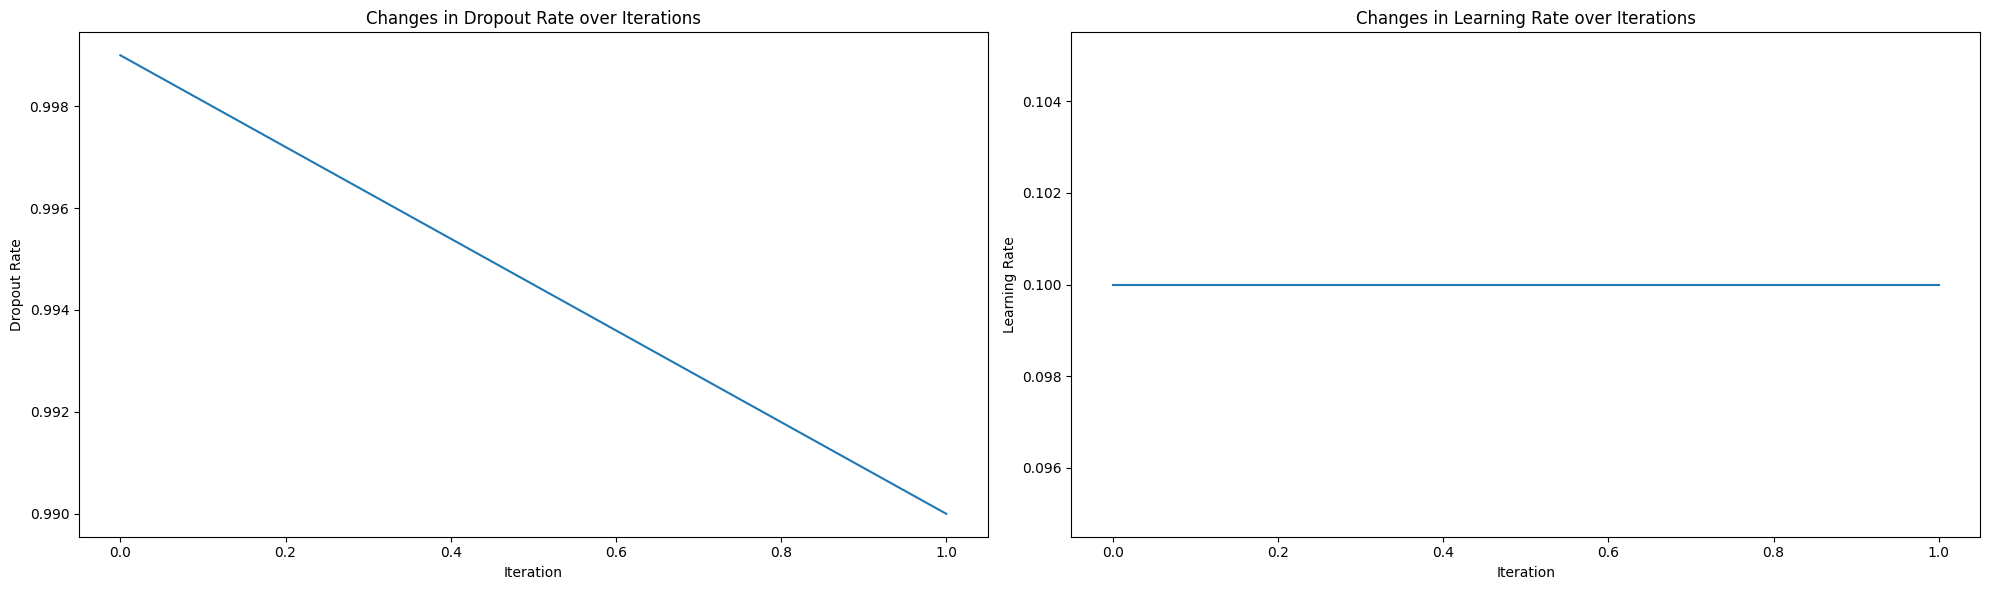

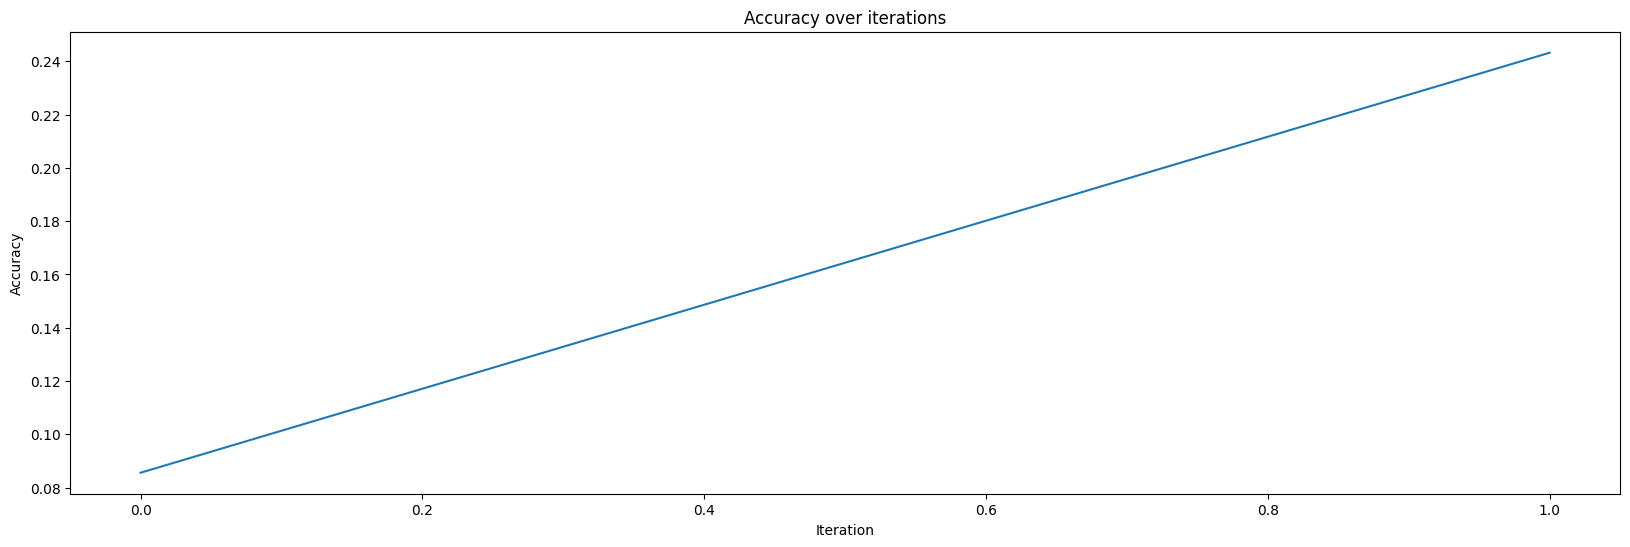

In [ ]:
#plot the changes in hyperparameters over iterations
plt.figure(figsize=(20, 6))

# Plot for Dropout Rate
plt.subplot(1, 2, 1)
plt.plot(dropout_rate_history)
plt.xlabel('Iteration')
plt.ylabel('Dropout Rate')
plt.title('Changes in Dropout Rate over Iterations')

# Plot for Learning Rate
plt.subplot(1, 2, 2)
plt.plot(learning_rate_history)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Changes in Learning Rate over Iterations')

plt.tight_layout()
plt.show()

#plot the accuracies changes over iterations
plt.figure(figsize=(20, 6))
plt.plot(accuracy_history)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations')
plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.update_layout(width=1500, height=800)
fig.update_layout(margin=dict(l=80, r=80, t=80, b=80),)
fig.add_trace(go.Surface(x=dropout_rate_range, y=learning_rate_range, z=Z, colorscale='Viridis', colorbar=dict(title='Accuracy')))
fig.add_trace(go.Scatter3d(x=[p[0] for p in trajectory], y=[p[1] for p in trajectory],
                           z=[-negative_accuracy(p) for p in trajectory], mode='markers+lines',
                           marker=dict(color='red', size=5),
                           line=dict(width=5, color='red'),
                           name='Optimization Trajectory'))

for i in range(1, len(trajectory)):
    x_start, y_start, z_start = trajectory[i-1][0], trajectory[i-1][1], -negative_accuracy(trajectory[i-1])
    x_end, y_end, z_end = trajectory[i][0], trajectory[i][1], -negative_accuracy(trajectory[i])

    fig.add_trace(go.Scatter3d(x=[trajectory[0][0]], y=[trajectory[0][1]],
                           z=[-negative_accuracy(trajectory[0])],
                           mode='markers', marker=dict(color='blue', size=6),
                           name='Initial Point'))

    fig.add_trace(go.Cone(x=[x_start], y=[y_start], z=[z_start],
                          u=[x_end - x_start], v=[y_end - y_start], w=[z_end - z_start],
                          sizemode="absolute", sizeref=0.01, showscale=False))

    fig.add_trace(go.Scatter3d(x=[trajectory[-1][0]], y=[trajectory[-1][1]],
                           z=[-negative_accuracy(trajectory[-1])],
                           mode='markers', marker=dict(color='black', size=5),
                           name='Final Point'))

fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
# Set layout properties
fig.update_layout(title=' Negative Accuracy with Optimization Trajectory',
                  scene=dict(xaxis_title='Dropout Rate', yaxis_title='Learning Rate', zaxis_title='Negative Accuracy'),
                  showlegend=True,
                  legend=dict(x=0.01, y=0.98, # Adjust these values to change legend position
                                 orientation='h',  # Use 'v' for vertical orientation
                                 traceorder='normal',  # Adjust trace order as needed
                                 bordercolor='gray', borderwidth=1, bgcolor='white'))
# Show the interactive 3D plot
fig.show()

In [ ]:
#plot all the accuracies changes over iterations
plt.figure(figsize=(20, 6))
plt.plot(accuracies_history_grid, label='Grid Search')
plt.plot(accuracies_history_random, label='Random Search')
plt.plot(accuracies_history_bayes, label='Bayesian Optimization')
plt.plot(accuracy_history, label='Gradient-based Optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations')
plt.legend()
plt.show()
